In [8]:
import numpy as np
import pandas as pd
from scipy import fftpack
from scipy import signal
import time
import os
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pylab
import pickle
import copy
import processing
import matplotlib.animation as animation
import datetime
import multiprocessing as mp
import processing

%matplotlib inline

/home/takeyama/.pyenv/versions/takeyama/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


共通変数をここに定義

In [9]:
DataName='sensor1_AccXYZ'
SensorName='sensor1'
Axis='AccXYZ'
SampleNum=16
width=1000

In [10]:
WORKSPACE_PATH = '/home/takeyama/pywork/ipython/2016-07-11'

StudyDataPath=WORKSPACE_PATH+'/Study/'+DataName+'/'
if not os.path.exists(StudyDataPath): os.makedirs(StudyDataPath)

GlaphDataPath=WORKSPACE_PATH+'/Graph/'+DataName+'/spectrum/'
if not os.path.exists(GlaphDataPath): os.makedirs(GlaphDataPath)

StudyDataModelPicPath=WORKSPACE_PATH+'/Study/'+DataName+'/modelPic/'
if not os.path.exists(StudyDataModelPicPath): os.makedirs(StudyDataModelPicPath)

WindowDataPath=WORKSPACE_PATH+'/window/'
RawDataPath=WORKSPACE_PATH+'/raw/'

In [11]:
"""
    encordData,decordData
    firstNum:
    goalNum:
    commonLabel:共通名前
"""
def MakeGlaph(encordData,decordData,firstNum,goalNum,commonLabel):
    eRow, eCol=encordData.shape
    dRow, dCol=decordData.shape
    
    if eRow!=dRow | eCol!=dCol:
        return -1
    start = firstNum
    goal=goalNum
    print str(start)+' is start '+str(goal)+' is goal'
    dataE = encordData.reshape(eRow*eCol,1)[start:goal]
    dataD = decordData.reshape(dRow*dCol,1)[start:goal]
    plt.clf() 
    plt.figure(figsize=(100,50))
    plt.plot(range(0,len(dataE)),dataE,'--r',label="raw data")
    plt.plot(range(0,len(dataD)),dataD,'b',label="reconstruct")
    plt.legend(loc='best')
    plt.title(str(start)+"-"+str(goal))
    plt.savefig(commonLabel+'-'+str(start)+"-"+str(goal)+'-'+'glaph')
    plt.clf()
    plt.cla()
    plt.close('all')
    return 1

すべてのデータを読みdし、グラフ化する

並列処理でグラフを作成する

Graph range=0 : 1000
Graph range=1000 : 2000
Graph range=2000 : 3000
Graph range=3000 : 4000
Graph range=4000 : 5000
Graph range=5000 : 6000
Graph range=6000 : 7000
Graph range=7000 : 8000
Graph range=8000 : 9000
Graph range=9000 : 10000
Graph range=10000 : 11000
Graph range=11000 : 12000
Graph range=12000 : 13000
Graph range=13000 : 14000
Graph range=14000 : 15000
Graph range=0 : 1000
Graph range=1000 : 2000
Graph range=2000 : 3000
Graph range=3000 : 4000
Graph range=4000 : 5000
Graph range=5000 : 6000
Graph range=6000 : 7000
Graph range=7000 : 8000
Graph range=8000 : 9000
Graph range=9000 : 10000
Graph range=10000 : 11000
Graph range=11000 : 12000
Graph range=12000 : 13000
Graph range=13000 : 14000
Graph range=14000 : 15000
Graph range=0 : 1000
Graph range=1000 : 2000
Graph range=2000 : 3000
Graph range=3000 : 4000
Graph range=4000 : 5000
Graph range=5000 : 6000
Graph range=6000 : 7000
Graph range=7000 : 8000
Graph range=8000 : 9000
Graph range=9000 : 10000
Graph range=10000 : 11000


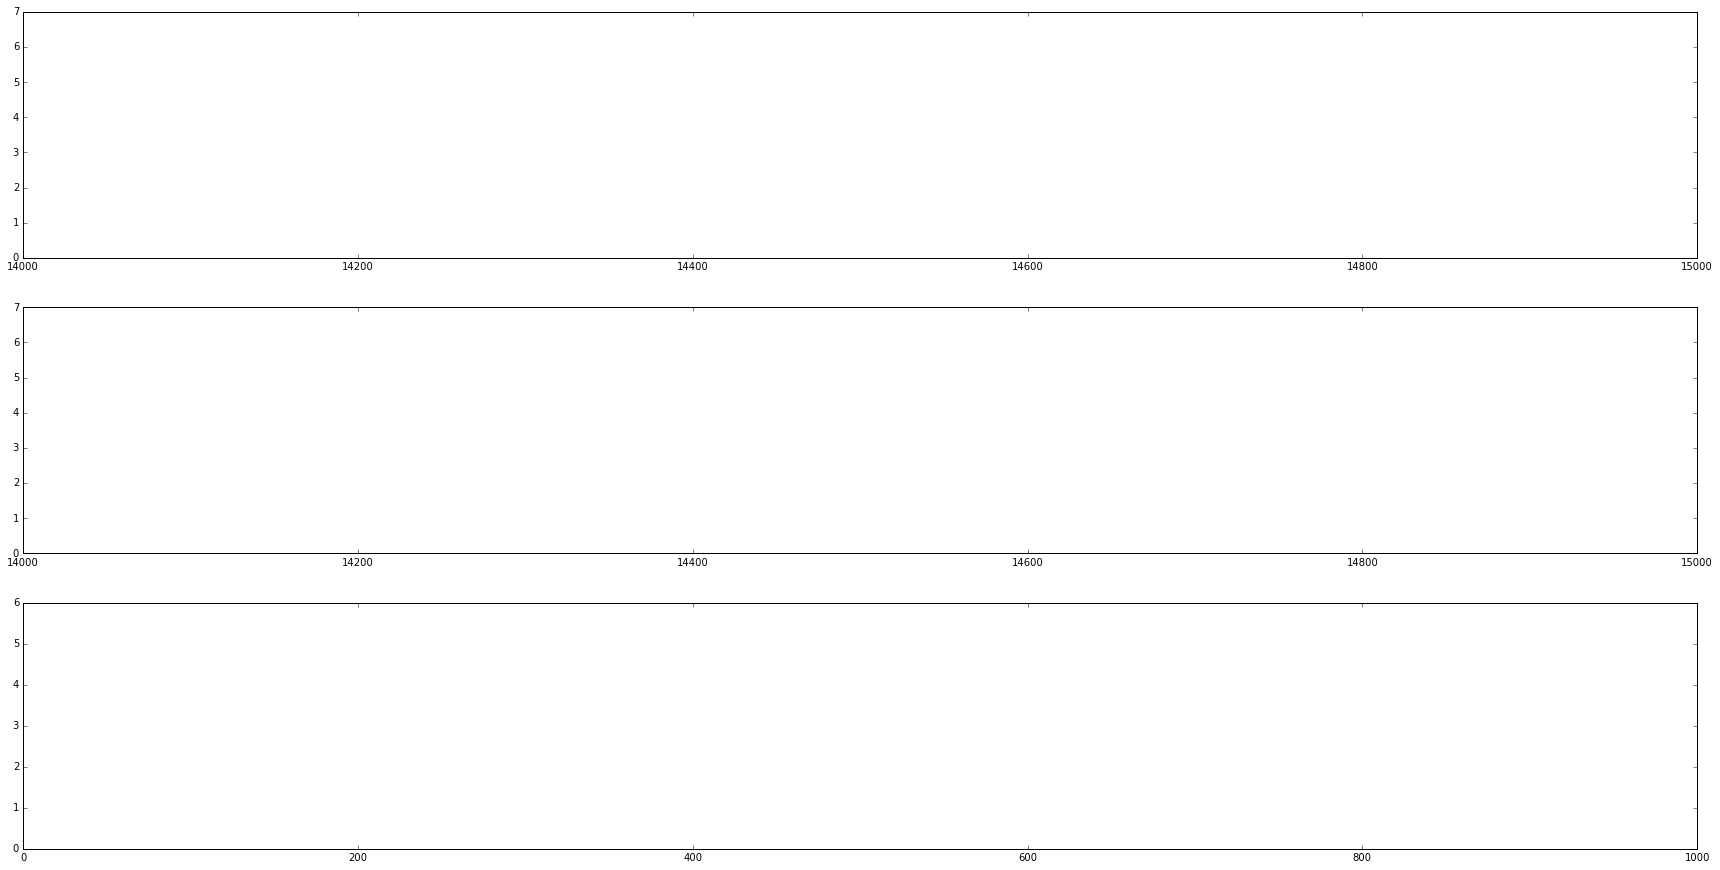

In [12]:
# define SaveFileName
# 8, 4, 12, 16, 32, 64
# 32 floats -> compression of factor 24.5, assuming the input is 784 floats
def kld(p, q):
    """Calculates Kullback–Leibler divergence"""
    p = np.array(p)
    q = np.array(q)
    return np.sum(p * np.log(p / q), axis=(p.ndim - 1))
 
def jsd(p, q):
    """Calculates Jensen-Shannon Divergence"""
    p = np.array(p)
    q = np.array(q)
    m = 0.5 * (p + q)
    return 0.5 * kld(p, m) + 0.5 * kld(q, m)

AllEncoding_dim = [4, 8, 12, 16, 32, 64]  
window = processing.LoadDicDataFromFileNPZ(WindowDataPath+SensorName+'_'+Axis+'_train_edim=8.npz')
rows,colms=window.shape
window = window.reshape(rows,colms/3,3)
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(311)
bx = fig.add_subplot(312)
cx = fig.add_subplot(313)

AllWindow = [window[:,:,0],window[:,:,1],window[:,:,2]]
WindowName=['AccX','AccY','AccZ']

for rawData,name in zip(AllWindow,WindowName):
    for encoding_dim in AllEncoding_dim:
        SaveFileNameGraph=GlaphDataPath+ DataName+'_edim='+str(encoding_dim)+'-'+name

        PowerDataE=processing.LoadDicDataFromFileNPZ(StudyDataPath+DataName+'_edim='+str(encoding_dim)+'-'+name+'-power-raw.npz')
        PowerDataD=processing.LoadDicDataFromFileNPZ(StudyDataPath+DataName+'_edim='+str(encoding_dim)+'-'+name+'-power-restruct.npz')
        
         # to distribution
        DistributePowerDataE = np.array([])
        DistributePowerDataD = np.array([])

        for i in range( PowerDataE.shape[0] ):
            DistributePowerDataE = np.append(DistributePowerDataE,PowerDataE[i]/( np.sum(PowerDataE[i]) ))
        DistributePowerDataE = DistributePowerDataE.reshape(PowerDataE.shape)

        for i in range( PowerDataD.shape[0] ):
            DistributePowerDataD = np.append(DistributePowerDataD,PowerDataD[i]/( np.sum(PowerDataD[i]) ))
        DistributePowerDataD = DistributePowerDataD.reshape(PowerDataD.shape)

        processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+'_edim='+str(encoding_dim)+'-'+name+'-power-distribution-raw',DistributePowerDataE)
        processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+'_edim='+str(encoding_dim)+'-'+name+'-power-distribution-reconst',DistributePowerDataD)

        ArrayKLD = np.array([])

        # Kullback-leibler-divergence plot
        for i in range(DistributePowerDataE.shape[0]):
            ArrayKLD = np.append(ArrayKLD, kld(DistributePowerDataE[i],DistributePowerDataD[i]))

        for i in range(width,DistributePowerDataE.shape[0],width):
            start =i-width
            goal=i

            data = ArrayKLD[start:goal]
            dataE = DistributePowerDataE[start:goal]
            dataD = DistributePowerDataD[start:goal]

            #dataE,dataDをPower
            ax.pcolormesh(range(start,goal),range(dataE.shape[1]),dataE.T ,label='rawData')
            ax.legend(loc='best')
            ax.set_title(str(start)+"-"+str(goal))

            bx.pcolormesh(range(start,goal),range(dataD.shape[1]),dataD.T ,label='reconst' )
            bx.legend(loc='best')
            bx.set_title(str(start)+"-"+str(goal))

            cx.plot(range(0,len(data)),data,'g',label="kld data")
            cx.legend(loc='best')
            cx.set_title(str(start)+"-"+str(goal))
            ax.figure.savefig(SaveFileNameGraph+'-'+str(start)+"-"+str(goal)+'-'+'-glaph')
            ax.clear()
            bx.clear()
            cx.clear()
            print 'Graph range='+str(start)+' : '+str(goal)
            time.sleep(3)

In [13]:
window.size

764208

In [14]:
fftDataD.shape

NameError: name 'fftDataD' is not defined